In [619]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import re
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Titanic - Random Forest, Decision Tree Classifier
![Titanic](https://www.lamontagneart.com/wp-content/uploads/2020/11/TitanicPostPic.jpg)

# 1. Data Cleaning
* Concatenate both train and test data for easy cleaning
* Checking for null values
* Filling up null values

In [620]:
raw_train_df = pd.read_csv('../input/titanic/train.csv')
raw_test_df = pd.read_csv('../input/titanic/test.csv')
df = pd.concat([raw_train_df, raw_test_df])
df = df.reset_index(drop=True)
display(df)
df.isnull().sum()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

<h2>Cabin data (feature engineering)</h2>
<ul>
    <li>Categorise cabin data into cabin classes (A-F)</li>
    <li>Create new Cabin survival score, each cabin class will follow its mean for survival</li>
    <li>Default at ~0.5, cabins B,D,E at ~.75</li>


{'Survived': {'A': 0.4666666666666667,
  'B': 0.7446808510638298,
  'C': 0.5932203389830508,
  'D': 0.7575757575757576,
  'E': 0.7575757575757576,
  'F': 0.5833333333333334,
  'G': 0.5,
  'T': 0.0}}

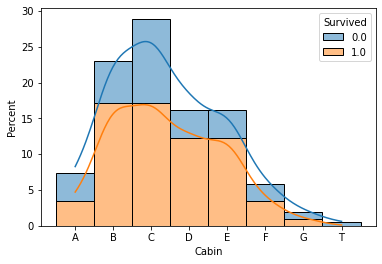

In [621]:
def cabin(x): #retain cabin class only, choose best available class
    x = re.sub(r'[^A-Z]','',x)
    if len(x)>1:
        x = min(x)
    return x

temp_df = df[['Survived', 'Cabin']].dropna()
#df_test[df_test['Cabin'].str.contains('[FE]', regex = True)]
temp_df['Cabin'] = temp_df['Cabin'].apply(cabin)
#df_test['Cabin_cat'].unique()
temp_df= temp_df.sort_values(by=['Cabin'])
sns.histplot(temp_df, x = 'Cabin', hue = 'Survived', multiple = 'stack', kde = True, stat = 'percent')
cabin_gb_df= temp_df.groupby('Cabin')
cabin_survival_df = cabin_gb_df.mean()
cabin_survival_dict = cabin_survival_df.to_dict(orient = 'dict')
cabin_survival_dict

In [622]:
def cabin_survival(x):#retain cabin class only, choose best available class
    x = re.sub(r'[^A-Z]','',x)
    if len(x)>1:
        x = min(x)
    x = cabin_survival_dict['Survived'][x] #assign cabin survival rate from previous data
    return x

df['Cabin'].fillna('G', inplace=True)
df['Cabin_survival']=df['Cabin'].apply(cabin_survival)
df[['Cabin_survival']].head()

,Cabin_survival
0,0.50000
1,0.59322
2,0.50000
3,0.59322
4,0.50000


<h2> Missing age and ports</h2>
<ul>
    <li>Fill null values for age using mean</li>
    <li>Drop two train data containing missing ports</li>

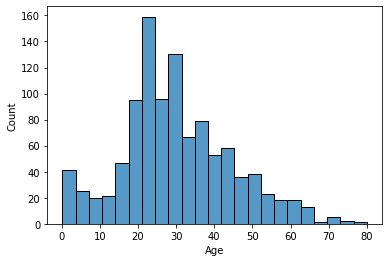

In [623]:
sns.histplot(df, x = 'Age');
df['Age'].fillna(df['Age'].mean(), inplace=True)

In [624]:
df[df['Embarked'].isnull()]
df.dropna(subset=['Embarked'], inplace=True)
df.isnull().sum()

PassengerId         0
Survived          418
Pclass              0
Name                0
Sex                 0
Age                 0
SibSp               0
Parch               0
Ticket              0
Fare                1
Cabin               0
Embarked            0
Cabin_survival      0
dtype: int64

<h2> Missing fare</h2>
Filling in Nullvalue of fare with the mean for Pclass 3, from Port S.

In [625]:
display(df[df['Fare'].isnull()])

temp_df = df.groupby(['Pclass','Embarked']).mean()
meanfare = temp_df.iloc[8,5]
display(temp_df)
print('Mean Fare for 3rd class and Southampton' ,meanfare)
df['Fare'].fillna(meanfare, inplace=True)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_survival
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,G,S,0.5


PassengerId  Survived        Age     SibSp     Parch  \
Pclass Embarked                                                         
1      C          700.702128  0.694118  38.215991  0.397163  0.368794   
       Q          654.000000  0.500000  38.000000  1.333333  0.000000   
       S          652.892655  0.582677  37.764574  0.457627  0.372881   
2      C          707.571429  0.529412  24.536591  0.500000  0.428571   
       Q          731.000000  0.666667  43.537468  0.000000  0.000000   
       S          665.681818  0.463415  29.700667  0.392562  0.371901   
3      C          671.940594  0.378788  24.871749  0.376238  0.356436   
       Q          665.115044  0.375000  28.266025  0.336283  0.123894   
       S          628.549495  0.189802  26.145796  0.660606  0.472727   

                       Fare  Cabin_survival  
Pclass Embarked                              
1      C         106.845330        0.629360  
       Q          90.000000        0.593220  
       S          72.148094        0.632687  
2      C          23.300593        0.536797  
       Q          11.735114        0.536797  
       S          21.206921        0.509798  
3      C          11.021624        0.507651  
       Q          10.390820        0.500737  
       S          14.435422        0.502234

Mean Fare for 3rd class and Southampton 14.435422064777327


In [626]:
df.isnull().sum()

PassengerId         0
Survived          418
Pclass              0
Name                0
Sex                 0
Age                 0
SibSp               0
Parch               0
Ticket              0
Fare                0
Cabin               0
Embarked            0
Cabin_survival      0
dtype: int64

<h2>Removing outliers (retired the code) - gave worse results</h2>
<p>We will replace outliers for fare (based on survival) with their respective medians.

#finds the outliers (>1.5IQR) and returns a list of PassengerIds which are outliers of their category
#then replaces these outliers with the Median

def remove_outliers(df, col, cond): 
    Q3 = np.quantile(df[cond][col], 0.75)
    Q1 = np.quantile(df[cond][col], 0.25)
    IQR = Q3 - Q1
    lower_range = Q1 - 1.5*IQR
    upper_range = Q3 + 1.5*IQR
    median = np.median(df[cond][col])

    print(f'IQR value for {col} is {IQR}')
    print(f'Lower range is {lower_range}')
    print(f'Upper range is {upper_range}')
    print(f'Median is {median}')

    cond2 = (df[col] < lower_range)
    cond3 = (df[col] > upper_range)

    outliers_cond = (cond&cond3)|(cond&cond3)
    outlier_id = df[outliers_cond]['PassengerId'].to_list()
    print('PassengerIds with outliers',outlier_id)
    print()
    df.loc[outlier_id,col]=Q3
    return

df.set_index('PassengerId', drop=False ,inplace=True) #set index to PassengerID so that we may find the outliers later

#remove_outliers(df, 'Fare', (df['Pclass']==1))
#remove_outliers(df, 'Fare', (df['Pclass']==2))
#remove_outliers(df, 'Fare', (df['Pclass']==3))

remove_outliers(df, 'Fare', (df['Survived']==0))
remove_outliers(df, 'Fare', (df['Survived']==1))

<h2>Feature Engineering</h2>
<h3>Survival by Status</h3>
<p>1. Noble men had a higher survival rate than normal men</p>
<p>2. Noble women had a 100% survival rate</p>
<p>3. Certain titles did not survive</p>
<p>4. Females in general have an overall higher survival rate</p>

In [627]:
df['Last Name'] = df.Name.apply(lambda x: x.split(',')[0].lower())
df['Status'] = df.Name.apply(lambda x: x.split(',')[1].lower().split('.')[0])

In [628]:
mapping = {' mlle': 'miss', ' ms': 'miss',' miss':'miss',' mrs':'mrs',' mr':'mr',
           ' col':'noble_m',' major': 'noble_m',' master' :'noble_m', ' sir': 'noble_m',' dr':'noble_m',
           ' mme': 'noble_f', ' lady': 'noble_f', ' the countess': 'noble_f',
           ' capt': 'noble_m', ' don': 'noble_m', ' jonkheer': 'noble_m', ' dona': 'noble_f', ' rev': 'noble_m'}
df.replace({'Status': mapping}, inplace=True)

Percentage %
           Survived
Status             
miss      70.108696
mr        15.667311
mrs       79.032258
noble_f  100.000000
noble_m   47.540984



<AxesSubplot:xlabel='Status', ylabel='Count'>

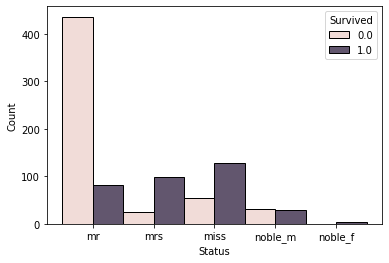

In [629]:
cond = (df['Survived']==1)
survived = df[cond].groupby('Status').count()

print('Percentage %')
status_survival = survived[['Survived']] / df.groupby('Status')[['Survived']].count()*100
print(status_survival)
print()

sns.histplot(df, x = 'Status', hue = 'Survived', multiple = 'dodge')

OLD CODE
cond_family = (df['SibSp']>0) | (df['Parch']>0)
gb = (df[cond_family].groupby('Last Name')['Survived'].count())/(df[cond_family].groupby('Last Name')['Name'].count())

#gb = (df.groupby('Last Name')['Survived'].count())/(df.groupby('Last Name')['Name'].count())
gb = gb.to_frame().reset_index()
cond_survivor = (gb.iloc[:,1]==1)
survivor_names = gb[cond_survivor]['Last Name'].to_list()
print('List of survivor names with family \n')
print(survivor_names)
df['Name_survival'] = df[cond_family]['Last Name'].apply(lambda x: 1 if x in survivor_names else 0.5)
df['Name_survival'].fillna(0.5, inplace=True)
df[cond_family][['Last Name','Name_survival']].head()

<h3>Passengers who were alone had a lower survival rate</h3>

In [630]:
cond_alone = (df['SibSp']==0) & (df['Parch']==0)
gb = df[cond_alone]['Survived'].count() / df['PassengerId'].count()*100
print('Rate of survival for passengers who were alone is', round(gb,3), '%')

df['Alone'] = df['SibSp']+df['Parch']
df['Alone'] = df['Alone'].apply(lambda x: 1 if x==0 else 0)
df[df['Alone']==1][['SibSp','Parch','Alone']]

Rate of survival for passengers who were alone is 40.933 %


,SibSp,Parch,Alone
2,0,0,1
4,0,0,1
5,0,0,1
6,0,0,1
11,0,0,1
...,...,...,...
1303,0,0,1
1304,0,0,1
1305,0,0,1
1306,0,0,1


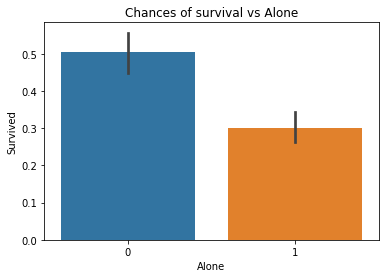

In [631]:
plt.title('Chances of survival vs Alone')
sns.barplot(data=df, x="Alone", y= 'Survived')
plt.show()

<h2>Removing all the unecessary features</h2>

In [632]:
clean_df = df.drop(['PassengerId','Fare','Ticket','Name','Cabin','SibSp','Parch','Last Name'],axis = 1)
clean_df.reset_index(drop = True, inplace=True)
clean_df

,Survived,Pclass,Sex,Age,Embarked,Cabin_survival,Status,Alone
0,0.0,3,male,22.000000,S,0.50000,mr,0
1,1.0,1,female,38.000000,C,0.59322,mrs,0
2,1.0,3,female,26.000000,S,0.50000,miss,1
3,1.0,1,female,35.000000,S,0.59322,mrs,0
4,0.0,3,male,35.000000,S,0.50000,mr,1
...,...,...,...,...,...,...,...,...
1302,NaN,3,male,29.881138,S,0.50000,mr,1
1303,NaN,1,female,39.000000,C,0.59322,noble_f,1
1304,NaN,3,male,38.500000,S,0.50000,mr,1
1305,NaN,3,male,29.881138,S,0.50000,mr,1


# 2. Preprocessing
* Sex will be defaulted to male

In [633]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
encoded = pd.DataFrame(enc.fit_transform(clean_df[['Sex','Embarked','Status']]).toarray())
display(enc.get_feature_names())
encoded.columns = ['Female','Male','Cherbourg','Queenstown','Southampton', 
                   'Miss' ,'Mr', 'Mrs', 'NobleF', 'NobleM']
encoded = encoded.drop(['Female','Mrs','Mr','Miss'],axis = 1) #default gender 0 will be male
encoded


array(['x0_female', 'x0_male', 'x1_C', 'x1_Q', 'x1_S', 'x2_miss', 'x2_mr',
       'x2_mrs', 'x2_noble_f', 'x2_noble_m'], dtype=object)

,Male,Cherbourg,Queenstown,Southampton,NobleF,NobleM
0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
1302,1.0,0.0,0.0,1.0,0.0,0.0
1303,0.0,1.0,0.0,0.0,1.0,0.0
1304,1.0,0.0,0.0,1.0,0.0,0.0
1305,1.0,0.0,0.0,1.0,0.0,0.0


In [634]:
processed_df = clean_df.join(encoded)
processed_df = processed_df.drop(['Sex','Embarked','Status'],axis = 1)
processed_df

,Survived,Pclass,Age,Cabin_survival,Alone,Male,Cherbourg,Queenstown,Southampton,NobleF,NobleM
0,0.0,3,22.000000,0.50000,0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.0,1,38.000000,0.59322,0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,3,26.000000,0.50000,1,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,1,35.000000,0.59322,0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,3,35.000000,0.50000,1,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1302,NaN,3,29.881138,0.50000,1,1.0,0.0,0.0,1.0,0.0,0.0
1303,NaN,1,39.000000,0.59322,1,0.0,1.0,0.0,0.0,1.0,0.0
1304,NaN,3,38.500000,0.50000,1,1.0,0.0,0.0,1.0,0.0,0.0
1305,NaN,3,29.881138,0.50000,1,1.0,0.0,0.0,1.0,0.0,0.0


In [635]:
training_set = processed_df['Survived'].isnull()==False 
train_df = processed_df[training_set]
train_df['Survived'] = train_df['Survived'].astype(int)
print('Train data')
display(train_df)

print()

testing_set = processed_df['Survived'].isnull()
test_df = processed_df[testing_set]
test_df = test_df.drop('Survived', axis = 1)
print('Test data')
test_df

Train data


,Survived,Pclass,Age,Cabin_survival,Alone,Male,Cherbourg,Queenstown,Southampton,NobleF,NobleM
0,0,3,22.000000,0.500000,0,1.0,0.0,0.0,1.0,0.0,0.0
1,1,1,38.000000,0.593220,0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,3,26.000000,0.500000,1,0.0,0.0,0.0,1.0,0.0,0.0
3,1,1,35.000000,0.593220,0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,3,35.000000,0.500000,1,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
884,0,2,27.000000,0.500000,1,1.0,0.0,0.0,1.0,0.0,1.0
885,1,1,19.000000,0.744681,1,0.0,0.0,0.0,1.0,0.0,0.0
886,0,3,29.881138,0.500000,0,0.0,0.0,0.0,1.0,0.0,0.0
887,1,1,26.000000,0.593220,1,1.0,1.0,0.0,0.0,0.0,0.0



Test data


,Pclass,Age,Cabin_survival,Alone,Male,Cherbourg,Queenstown,Southampton,NobleF,NobleM
889,3,34.500000,0.50000,1,1.0,0.0,1.0,0.0,0.0,0.0
890,3,47.000000,0.50000,0,0.0,0.0,0.0,1.0,0.0,0.0
891,2,62.000000,0.50000,1,1.0,0.0,1.0,0.0,0.0,0.0
892,3,27.000000,0.50000,1,1.0,0.0,0.0,1.0,0.0,0.0
893,3,22.000000,0.50000,0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1302,3,29.881138,0.50000,1,1.0,0.0,0.0,1.0,0.0,0.0
1303,1,39.000000,0.59322,1,0.0,1.0,0.0,0.0,1.0,0.0
1304,3,38.500000,0.50000,1,1.0,0.0,0.0,1.0,0.0,0.0
1305,3,29.881138,0.50000,1,1.0,0.0,0.0,1.0,0.0,0.0


# 3. EDA of the training data to confirm features


**Correlations**
* Survival has a -0.54 corr with Male
* Survival has a -0.34 corr with Pclass
* Survival has a 0.17 corr with Cherbourg (port)
* Survival has a -0.21 corr with Alone

**We will visualise the correlations for a better understanding**

<AxesSubplot:>

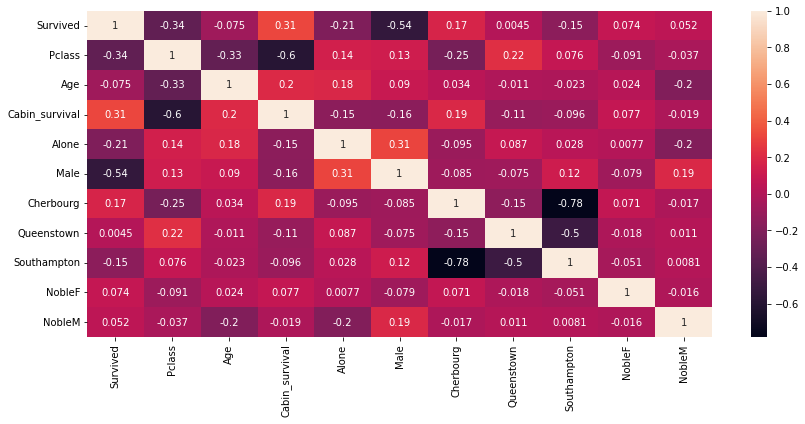

In [636]:
#train_df.corr().style.background_gradient()
#pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
#sibsp	of siblings / spouses aboard the Titanic
#parch	of parents / children aboard the Titanic
plt.figure(figsize=(14,6))
sns.heatmap(train_df.corr(), annot=True)

In [637]:
def survival(x):
    if x == 1:
        return 'Yes'
    else:
        return 'No'

def pclass(x):
    if x == 1:
        return '1st Class'
    elif x == 2:
        return '2nd Class'
    else:
        return '3rd Class'
    
cat_df = raw_train_df
cat_df['Pclass'] = raw_train_df['Pclass'].apply(pclass)
cat_df['Survived'] = raw_train_df['Survived'].apply(survival)

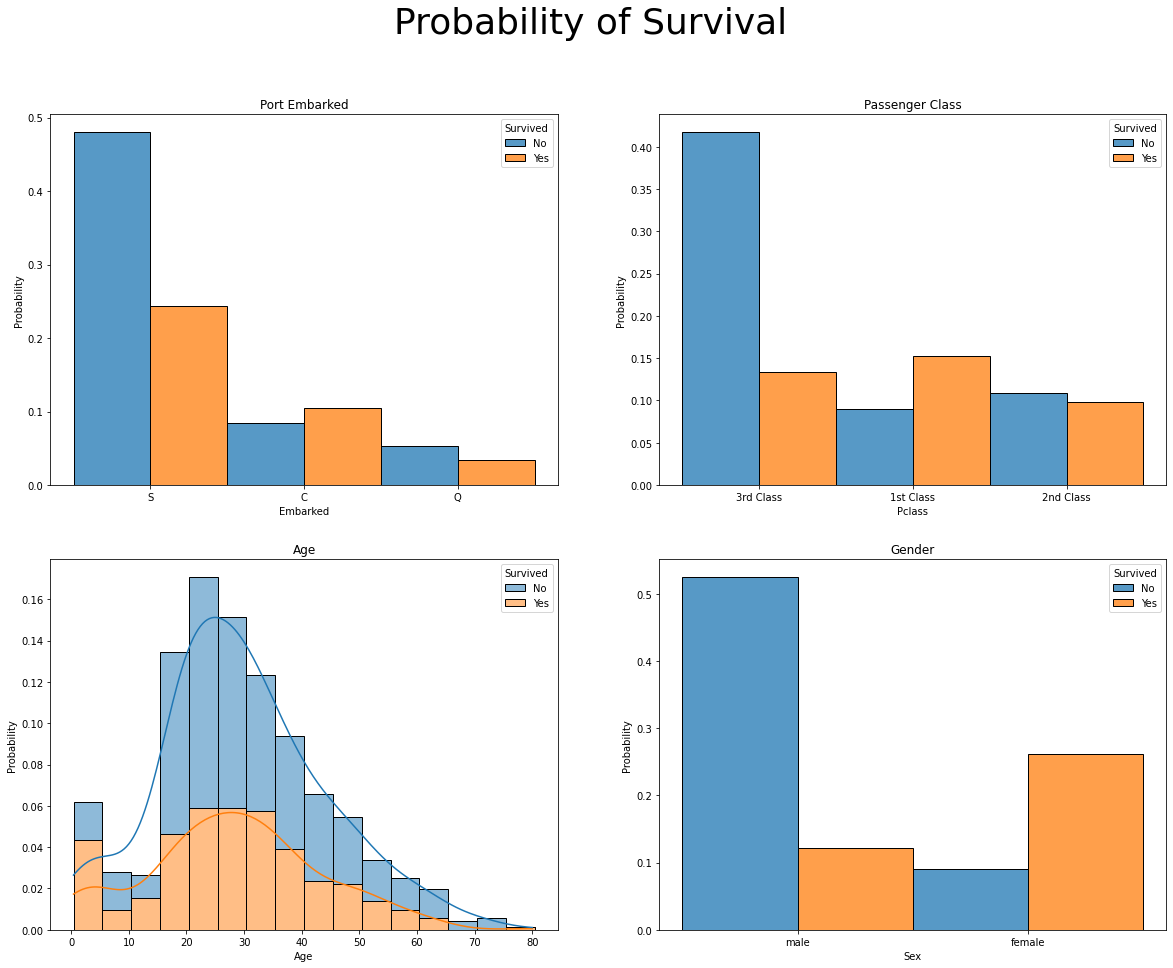

In [638]:
fig = plt.figure(figsize=(20,15))
plt.suptitle("Probability of Survival", fontsize = 36)
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.title.set_text('Port Embarked')
sns.histplot(cat_df, x='Embarked', hue = 'Survived', multiple = 'dodge', stat='probability', ax = ax1)

ax2.title.set_text('Passenger Class')
sns.histplot(cat_df, x = 'Pclass', hue = 'Survived', multiple = 'dodge', stat='probability', ax = ax2)

ax3.title.set_text('Age')
sns.histplot(raw_train_df, x = 'Age', hue = 'Survived', multiple = 'stack', binwidth = 5, kde=True, stat='probability', ax = ax3)

ax4.title.set_text('Gender')
sns.histplot(raw_train_df, x = 'Sex', hue = 'Survived', multiple = 'dodge', stat='probability', ax = ax4)
plt.show()

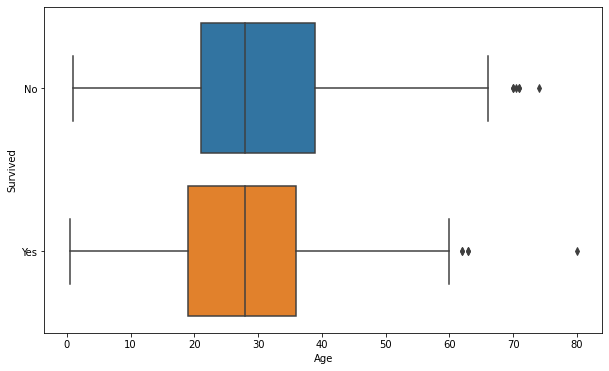

In [639]:
fig = plt.figure(figsize=(10,6))
sns.boxplot(data=cat_df, x="Age", y="Survived")
plt.show()

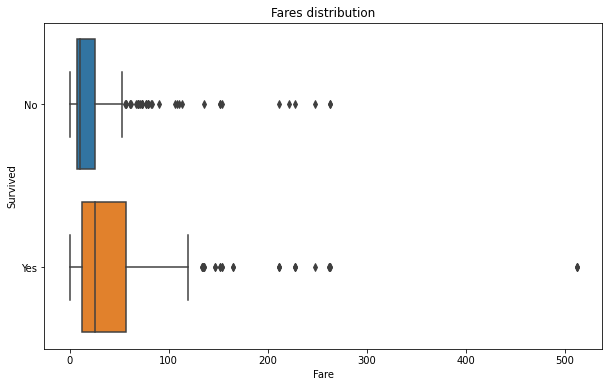

In [640]:
fig = plt.figure(figsize=(10,6))
plt.title('Fares distribution')
sns.boxplot(data=cat_df, x="Fare", y="Survived")
plt.show()

# 4. Decision Tree Classifier

In [641]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

X = train_df.drop('Survived',axis = 1)
y = train_df[['Survived']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

depths = [3,6,9]

for n in depths:
    clf = DecisionTreeClassifier(max_depth = n, random_state=42)
    clf.fit(X_train, y_train)
    
    print('Max depth', clf.tree_.max_depth)
    prediction = clf.predict(X_test)
    print('Model accuracy: {0:0.4f}'.format(accuracy_score(y_test, prediction)))
    print('Precision score: {0:0.4f}'.format(precision_score(y_test, prediction)))
    print(confusion_matrix(y_test, prediction))
    print()
    feature_names= X.columns.to_list()
    importances = clf.feature_importances_
    
    i = 0
    while i < len(feature_names):
        print('Feature importance:',feature_names[i], round(importances[i],2)*100, '%')
        i +=1
    print()

Max depth 3
Model accuracy: 0.8095
Precision score: 0.8293
[[170  14]
 [ 42  68]]

Feature importance: Pclass 16.0 %
Feature importance: Age 0.0 %
Feature importance: Cabin_survival 6.0 %
Feature importance: Alone 0.0 %
Feature importance: Male 62.0 %
Feature importance: Cherbourg 3.0 %
Feature importance: Queenstown 0.0 %
Feature importance: Southampton 5.0 %
Feature importance: NobleF 0.0 %
Feature importance: NobleM 7.000000000000001 %

Max depth 6
Model accuracy: 0.8027
Precision score: 0.7889
[[165  19]
 [ 39  71]]

Feature importance: Pclass 14.000000000000002 %
Feature importance: Age 18.0 %
Feature importance: Cabin_survival 8.0 %
Feature importance: Alone 1.0 %
Feature importance: Male 46.0 %
Feature importance: Cherbourg 3.0 %
Feature importance: Queenstown 0.0 %
Feature importance: Southampton 5.0 %
Feature importance: NobleF 0.0 %
Feature importance: NobleM 5.0 %

Max depth 9
Model accuracy: 0.7993
Precision score: 0.7576
[[160  24]
 [ 35  75]]

Feature importance: Pclass 1

# 4. Random Forest Classifer

In [642]:
from sklearn.ensemble import RandomForestClassifier

depths = [3,5,7]

for n in depths:
    rf_clf = RandomForestClassifier(max_depth = n, random_state=42)
    rf_clf.fit(X_train, y_train)
    
    print('Max depth', n)
    prediction = rf_clf.predict(X_test)
    print('Model accuracy: {0:0.4f}'.format(accuracy_score(y_test, prediction)))
    print('Precision score: {0:0.4f}'.format(precision_score(y_test, prediction)))
    print(confusion_matrix(y_test, prediction))
    print()
    feature_names= X.columns.to_list()
    importances = rf_clf.feature_importances_
    
    i = 0
    while i < len(feature_names):
        print('Feature importance:',feature_names[i], round(importances[i],2)*100, '%')
        i +=1
    print()

Max depth 3
Model accuracy: 0.8129
Precision score: 0.8090
[[167  17]
 [ 38  72]]

Feature importance: Pclass 20.0 %
Feature importance: Age 8.0 %
Feature importance: Cabin_survival 11.0 %
Feature importance: Alone 4.0 %
Feature importance: Male 50.0 %
Feature importance: Cherbourg 3.0 %
Feature importance: Queenstown 1.0 %
Feature importance: Southampton 2.0 %
Feature importance: NobleF 0.0 %
Feature importance: NobleM 2.0 %

Max depth 5
Model accuracy: 0.8163
Precision score: 0.8111
[[167  17]
 [ 37  73]]

Feature importance: Pclass 18.0 %
Feature importance: Age 14.000000000000002 %
Feature importance: Cabin_survival 10.0 %
Feature importance: Alone 3.0 %
Feature importance: Male 45.0 %
Feature importance: Cherbourg 3.0 %
Feature importance: Queenstown 1.0 %
Feature importance: Southampton 3.0 %
Feature importance: NobleF 0.0 %
Feature importance: NobleM 3.0 %

Max depth 7
Model accuracy: 0.8129
Precision score: 0.8022
[[166  18]
 [ 37  73]]

Feature importance: Pclass 14.0000000000

# 5. Final model, fitted to all train data

In [643]:
rf_clf = RandomForestClassifier(max_depth = 5, random_state=42)
rf_clf.fit(X, y)

feature_names= X.columns.to_list()
importances = rf_clf.feature_importances_
i = 0
while i < len(feature_names):
    print('Feature importance:',feature_names[i], round(importances[i],2)*100, '%')
    i +=1
print()

Feature importance: Pclass 17.0 %
Feature importance: Age 13.0 %
Feature importance: Cabin_survival 11.0 %
Feature importance: Alone 3.0 %
Feature importance: Male 47.0 %
Feature importance: Cherbourg 2.0 %
Feature importance: Queenstown 1.0 %
Feature importance: Southampton 3.0 %
Feature importance: NobleF 0.0 %
Feature importance: NobleM 2.0 %



from sklearn.model_selection import RandomizedSearchCV as RSCV

param_grid = {'n_estimators':np.arange(50,200,15),
              'max_features':np.arange(0.1, 1, 0.1),
              'max_depth': [3, 5, 7, 9],
              'max_samples': [0.3, 0.5, 0.8]}

model = RSCV(RandomForestClassifier(), param_grid, n_iter = 15).fit(X, y)
rf = model.best_estimator_

print('Max depth', rf.max_depth)
print('Max features', rf.max_features)
print('Min samples split', rf.min_samples_split)

feature_names= X.columns.to_list()
importances = rf.feature_importances_
i = 0
while i < len(feature_names):
    print('Feature importance:',feature_names[i], round(importances[i],2)*100, '%')
    i +=1
print()

# Final Submission

In [644]:
ans = rf_clf.predict(test_df)
submission = pd.DataFrame({"PassengerId": raw_test_df['PassengerId'],
                           "Survived": ans}
                          )
display(submission)
submission.to_csv('submission.csv', index=False)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
